# The Timeseries Quantum Autoencoder - Data Exploration
*Compatible with Qiskit V1.02+*<br/>
*TS QAE in Qiskit with angle encoding of TS sliding windows*

By: Jacob Cybulski<br>
Date: August 2023 - February 2024<br>
Aims: The goal of this notebook is to build a Time Series Quantum Autoencoder, 
    a circuit which can compress a quantum state of a timeseries onto a smaller amount of qubits, 
    while retaining the information from the initial state.
Methods: A QAE model from Qiskit Tutorial 12 has been adopted for time series processing. 
- Time series data was converted to a series of sliding windows.
- Several approaches to TS data encoding were tested, i.e. unary, binary and anglular.
- Angle encoding was eventually used, with values centered around H state, in the range of [-pi/2..pi/2]
- The model featuring an input and encoder blocks only (followed by a swap test) was subsequently trained.
- A decoder was then added for testing, and the circuit initialised with an optimum set of parameters from training.
- Each test sample was then encoded into the full QAE circuit, which was executed using a state vector simulation.
- State vectors of input and output data was then visualised and compared. 

Sources: 
1. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017. “Quantum Autoencoders for Efficient Compression of Quantum Data.” Quantum Science and Technology 2 (4): 045001.
2. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021
3. Qiskit Tutorial, https://qiskit.org/ecosystem/machine-learning/tutorials/12_quantum_autoencoder.html. *Based on [1].*
4. Eugenia Anello, Denoising Autoencoder in Pytorch on MNIST dataset, Dataseries (Medium), Jun 28, 2021.
5. Eugenia Anello, <a href="https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/denAE.ipynb">GitHub</a>, Jun 28, 2021.
6. Phillip Lippe, Tutorial 9: Deep Autoencoders, UvA Deep Learning Tutorials, Fall 2022.

Notes:
- Refer to the end of the notebook for the log of changes
- Algorithm by Romera was followed
- Results of the enhanced algorithm by Bravo-Prieto could not be reproduced

## Initial settings

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl-cuda12/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl-cuda12/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import math
from IPython.display import clear_output
%matplotlib inline

from utils.Target import *
from utils.Window import *
from utils.Callback import *
from utils.TS import *
from utils.Integrate import *

from utils.Charts import *
from utils.Angles import *
from utils.Files import *

from matplotlib import set_loglevel
set_loglevel("error")

## Prepare windowed TS data
*Values need to be in [-1..+1] range*

### Prepare time series

In [4]:
# ### Start random process
# from qiskit_algorithms.utils import algorithm_globals
# algorithm_globals.random_seed = 2022

In [5]:
## Software version
major_version = 4
minor_version = 2

### Data settings
samples = 160
split = 0.75

### Define the time series parameters
#   wind_size: sliding window size (which may be the same as number of qubits)
#   horizon:   the number of time events to look ahead (to forecast)
wind_size = 8
wind_step = 4
horizon = 1
scale = 1 # 2
pan = 0 # -1

### Noise level
noise = 0.03
noise_reps = 1

In [6]:
### Constants
LOG_NAME = 'beer_pl'
DATA_NAME = 'beer'
DATA_PATH = f'{LOG_NAME}/data'
FIGURES_PATH = f'{LOG_NAME}/figures'

### Create a folder if needed
create_folder_if_needed(DATA_PATH)
create_folder_if_needed(FIGURES_PATH)

### Show constants
(LOG_NAME, DATA_NAME, DATA_PATH, FIGURES_PATH)

('beer_pl', 'beer', 'beer_pl/data', 'beer_pl/figures')

In [7]:
### All created files have the following codes:
#   n: sample size
#   w: window size
#   ws: window step
#   z: level of noise injected
#   zr: replication number of noisy records
DATA_PREF = f'{DATA_NAME}_n{samples}_w{wind_size}_ws{wind_step}_z{noise}_zr{noise_reps}'
DATA_PREF

'beer_n160_w8_ws4_z0.03_zr1'

### Generate TS with options



TS noise = 3.0%, calculated noise = 1.56%, total noise = 3.6858, over the points = 232



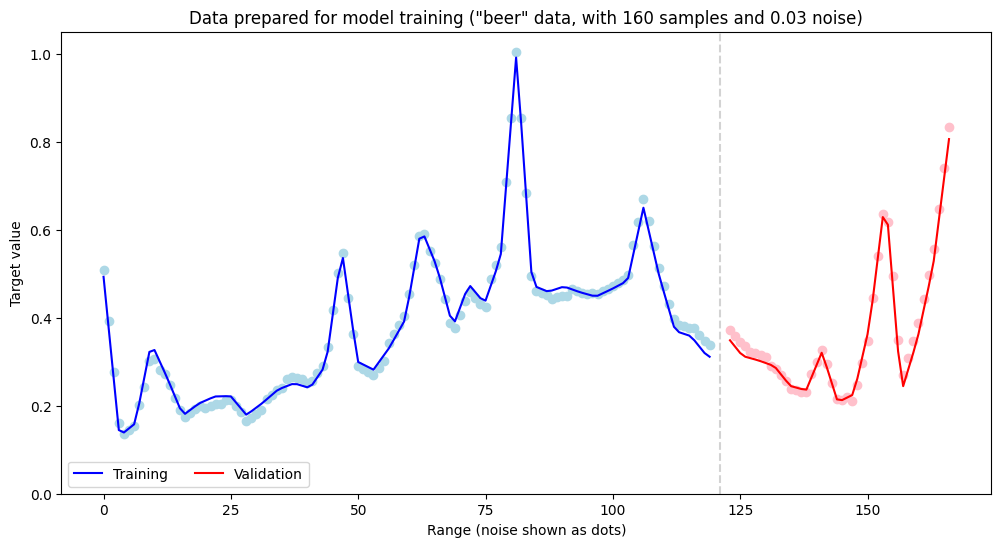

In [8]:
### Select a target class and its parameters (see: utils.py), e.g.
#   Target_sin() # Target_2_sins() # Target_poly() # Target_poly_3()
#   Target_line() # Target_line(slope=0.5, intercept=0.2, xmin=0, xmax=1.5)
#   Target_trig_trend() # Target_jitter()
#   Target_beer() # 
#   Target_beer(pt_from=104, pt_to=156) # As per ICCS'2024
#   Target_beer(pt_from=64, pt_to=204) # Test 2

fun_train = Target_beer(pt_from=104, pt_to=156) # As per ICCS'2024

### Create original data
X_train_org, y_train_org, X_valid_org, y_valid_org = \
    gen_ts_windows(fun_train, samples, split, wind_size, wind_step, differencing=False,
                   debug=False, title='\nGenerating windows from the original pure data')

### Add noise to this data
_, y_train_noisy_org = gen_noisy_ts(X_train_org, y_train_org, noise=noise)
_, y_valid_noisy_org = gen_noisy_ts(X_valid_org, y_valid_org, noise=noise)

### Plot referenced data, pure and noisy, for training and validation 

itg_integrated_plot(y_train_org, y_valid_org, y_train_noisy_org, y_valid_noisy_org, wind_step, noise,
     labels=['Training', 'Validation'], xlabel='Range (noise shown as dots)', ylabel='Target value',
     title=f'Data prepared for model training ("{DATA_NAME}" data, with {samples} samples and {noise} noise)',
     # line_styles={'train_pure':'solid', 'train_noisy':'none', 'valid_pure':'solid', 'valid_noisy':'none'},
     cols = {'train_pure':'blue', 'train_noisy':'lightblue', 'valid_pure':'red', 'valid_noisy':'pink'},
     marker_style='o', ylim=(0, 1.05), save_plot=f'{FIGURES_PATH}/data_{DATA_PREF}_pure_and_noise_ref.eps')
print()


Generating windows from differenced TS

Function: Target_beer, Eps: 0.1
Samples: 160, Split: 0.75, Train Samples: 120, Valid Samples: 40
Window Size: 8, Step: 4, Horizon: 0
Differencing: True, noise type="abs", noise added=0
Training Windows: 29, Validation Windows: 10


TS noise = 3.0%, calculated noise = 5.06%, total noise = 4.5273, over the points = 232



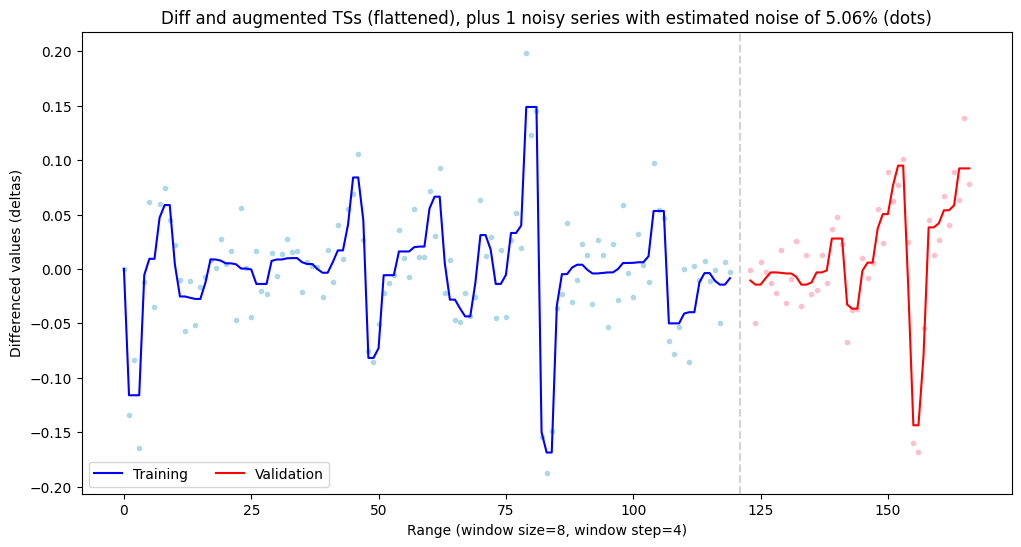

In [9]:
### Create differenced curves - pure and noisy, repeat noisy curves

X_train_ts, y_train_ts, X_valid_ts, y_valid_ts = \
    gen_ts_windows(fun_train, samples, split, wind_size, wind_step, differencing=True,
                   debug=True, title='\nGenerating windows from differenced TS')

### Generate noisy sets foe differenced TSs

y_train_noisy_ts = []; y_valid_noisy_ts = []

for ni in range(noise_reps):

    # Add noise to this data
    _, y_train_noisy_ts_1, _, y_valid_noisy_ts_1 = \
        gen_ts_windows(fun_train, samples, split, wind_size, wind_step, differencing=True, noise=noise,
                       debug=False, title=f'\nGenerating windows from differenced TS with added noise (set {ni})')
    
    # Collect noisy TSs
    y_train_noisy_ts.append(y_train_noisy_ts_1)
    y_valid_noisy_ts.append(y_valid_noisy_ts_1)

y_train_noisy_ts = np.array(y_train_noisy_ts)
y_valid_noisy_ts = np.array(y_valid_noisy_ts)

### Plot differenced curves 

itg_diffaug_plot(y_train_ts, y_valid_ts, y_train_noisy_ts, y_valid_noisy_ts, wind_step, noise, noise_reps,
                 xlabel=f'Range (window size={wind_size}, window step={wind_step})',
                 ylabel='Differenced values (deltas)', 
                 save_plot=f'{FIGURES_PATH}/data_{DATA_PREF}_pure_and_noise_diff.eps')
print()

### Angle encoding
Deltas between consecutive time series values have been angle encoded. In the context of a quibit representation (see the Figure), the encoding assumes zero to be encoded as H state, negative values to be rotations up, while positive values as rotations down. This encoding allows cumulative sequence calculations and easy value decoding upong the qubit measurements. Should there be huge voilatility in data, additional scaling has been added to shrink the region of valid angular qubit positions. 

<div>
    <!--img src="attachment:qae_fig2_wide.png" width="1000"-->
    <img src="../images/seq-value-encoding.png" width="300">
</div>

**Figure: Sequence value coding as qubit angular rotations**

### Encoding and augmenting data for training and testing

In [10]:
### Encoding of TS windows which are 
y_train_enc_part, org_train_start = ts_relang_encode(y_train_ts)
y_valid_enc_part, org_valid_start = ts_relang_encode(y_valid_ts)

# Encode a list of noisy TS windows 
y_train_noisy_enc_part = [ts_relang_encode(ts)[0] for ts in y_train_noisy_ts]
y_valid_noisy_enc_part = [ts_relang_encode(ts)[0] for ts in y_valid_noisy_ts]

In [11]:
### Augmenting training data by adding mirror images of each window (before training and after validation sets)
y_train_enc = np.array([y[::-1] for y in reversed(y_train_enc_part)] + list(y_train_enc_part))
y_train_noisy_enc = np.array([[y[::-1] for y in reversed(enc_part)] + list(enc_part) for enc_part in y_train_noisy_enc_part])

### Validation data is used as is, if augmentation needed, used the commented lines here
#   y_valid_enc = np.array(list(y_valid_enc_part) + [y[::-1] for y in reversed(y_valid_enc_part)])
#   y_valid_noisy_enc = np.array([list(enc_part) + [y[::-1] for y in reversed(enc_part)] for enc_part in y_valid_noisy_enc_part])
y_valid_enc = np.array(y_valid_enc_part)
y_valid_noisy_enc = np.array(y_valid_noisy_enc_part)

print(f'y_train_enc.shape = {y_train_enc.shape}')
print(f'y_valid_enc.shape = {y_valid_enc.shape}')
print(f'y_train_noisy_enc.shape = {y_train_noisy_enc.shape}')
print(f'y_valid_noisy_enc.shape = {y_valid_noisy_enc.shape}')

y_train_enc.shape = (58, 8)
y_valid_enc.shape = (10, 8)
y_train_noisy_enc.shape = (1, 58, 8)
y_valid_noisy_enc.shape = (1, 10, 8)




TS noise = 3.0%, calculated noise = 5.06%, total noise = 28.4456, over the points = 464



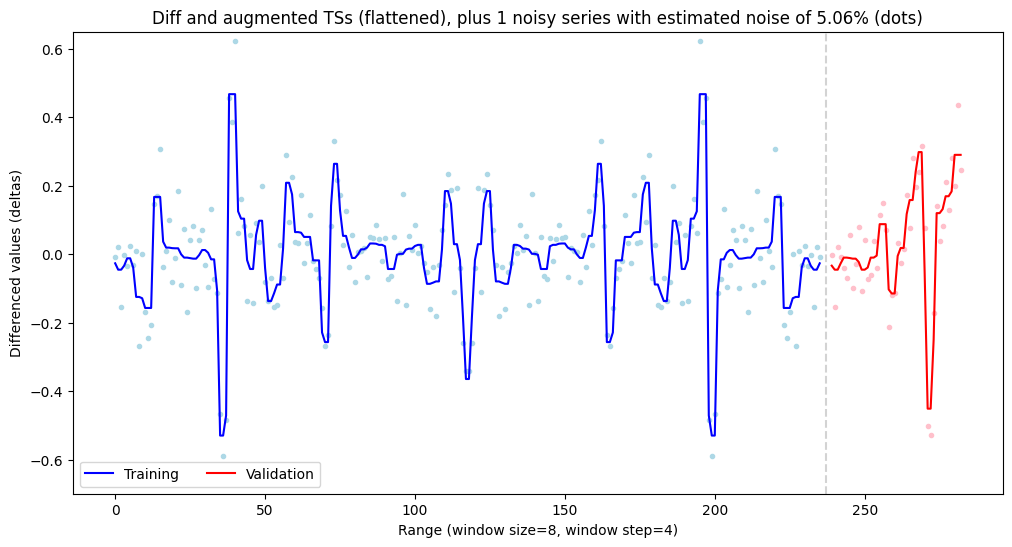

In [12]:
itg_diffaug_plot(y_train_enc, y_valid_enc, y_train_noisy_enc, y_valid_noisy_enc, wind_step, noise, noise_reps,
                 xlabel=f'Range (window size={wind_size}, window step={wind_step})',
                 ylabel='Differenced values (deltas)', ylim=(-0.7, 0.65), 
                 save_plot=f'{FIGURES_PATH}/data_{DATA_PREF}_pure_and_noise_aug.eps')

## Save generated data

In [13]:
### Define file names

y_train_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_org.arr'
y_valid_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_org.arr'
y_train_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_org.arr'
y_valid_noisy_org_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_org.arr'

y_train_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_ts.arr'
y_valid_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_ts.arr'
y_train_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_ts.arr'
y_valid_noisy_ts_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_ts.arr'

y_train_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_enc.arr'
y_valid_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_enc.arr'
y_train_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_train_noisy_enc.arr'
y_valid_noisy_enc_fpath = f'{DATA_PATH}/{DATA_PREF}_y_valid_noisy_enc.arr'

info_file_path = f'{DATA_PATH}/{DATA_PREF}_info.json'
info_default_path = f'{DATA_PATH}/info.json'


In [14]:
### Save data

data_to_be_saved = True

if data_to_be_saved:
    
    write_ts_file(y_train_org_fpath, y_train_org)
    write_ts_file(y_valid_org_fpath, y_valid_org)
    write_ts_file(y_train_noisy_org_fpath, y_train_noisy_org)
    write_ts_file(y_valid_noisy_org_fpath, y_valid_noisy_org)
    
    write_ts_file(y_train_ts_fpath, y_train_ts)
    write_ts_file(y_valid_ts_fpath, y_valid_ts)
    write_ts_file(y_train_noisy_ts_fpath, 
                  y_train_noisy_ts.reshape(
                      y_train_noisy_ts.shape[0]*y_train_noisy_ts.shape[1], 
                      y_train_noisy_ts.shape[2]))
    write_ts_file(y_valid_noisy_ts_fpath, 
                  y_valid_noisy_ts.reshape(
                      y_valid_noisy_ts.shape[0]*y_valid_noisy_ts.shape[1],
                      y_valid_noisy_ts.shape[2]))
    
    write_ts_file(y_train_enc_fpath, y_train_enc)
    write_ts_file(y_valid_enc_fpath, y_valid_enc)
    write_ts_file(y_train_noisy_enc_fpath, 
                  y_train_noisy_enc.reshape(
                      y_train_noisy_enc.shape[0]*y_train_noisy_enc.shape[1],
                      y_train_noisy_enc.shape[2]))
    write_ts_file(y_valid_noisy_enc_fpath, 
                  y_valid_noisy_enc.reshape(
                      y_valid_noisy_enc.shape[0]*y_valid_noisy_enc.shape[1],
                      y_valid_noisy_enc.shape[2]))
    
    print(f'Saved all data: "{DATA_PATH}" folder')
else:
    print(f'Data not saved') 

Saved all data: "beer_pl/data" folder


In [15]:
### Save info details
info_to_save = \
    {'data_name':DATA_NAME, 
     'major_version':major_version, 
     'minor_version':minor_version,
     'samples':samples,
     'split':split, 
     'wind_size':wind_size,
     'wind_step':wind_step, 
     'horizon':horizon, 
     'scale':scale, 
     'pan':pan,
     'noise':noise,
     'noise_reps': noise_reps}

### Saving the info file
write_json_file(info_file_path, info_to_save)
write_json_file(info_default_path, info_to_save)
    
print(f'\nSaved time series info in file "{info_file_path}":\n')
for k in info_to_save.keys():
    print(f'\tinfo[{k}] = {info_to_save[k]}')
print()


Saved time series info in file "beer_pl/data/beer_n160_w8_ws4_z0.03_zr1_info.json":

	info[data_name] = beer
	info[major_version] = 4
	info[minor_version] = 2
	info[samples] = 160
	info[split] = 0.75
	info[wind_size] = 8
	info[wind_step] = 4
	info[horizon] = 1
	info[scale] = 1
	info[pan] = 0
	info[noise] = 0.03
	info[noise_reps] = 1



## References

1. A wikipedia page on Autoencoder: https://en.wikipedia.org/wiki/Autoencoder

2. Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. "Quantum autoencoders for efficient compression of quantum data." Quantum Science and Technology 2.4 (2017): 045001.

3. Swap Test Algorithm: https://en.wikipedia.org/wiki/Swap_test

4. Bravo-Prieto, Carlos, "Quantum autoencoders with enhanced data encoding." Machine Learning: Science and Technology, 2, May 2021

# Software in use

In [18]:
!pip list | grep -e PennyLane -e torch

PennyLane                 0.36.0
PennyLane_Lightning       0.36.0
PennyLane_Lightning_GPU   0.36.0
PennyLane-Rigetti         0.36.0
torch                     2.3.1+cu121
torchaudio                2.3.1+cu121
torchsummary              1.5.1
torchvision               0.18.1+cu121
